In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/dataset_coba4"

In [5]:
# Define the desired number of samples per class
desired_samples_per_class = 15000

# Load and preprocess the dataset
images = []
labels = []

# Determine the number of photos per class
class_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    class_counts[label] = len(os.listdir(label_dir))
num_photos_per_class = min(class_counts.values())

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

label_encoder = LabelEncoder()
label_encoder.fit(os.listdir(dataset_dir))  # Fit the label encoder to the label names

for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    num_generated_samples = 0
    while num_generated_samples < desired_samples_per_class:
        for filename in os.listdir(label_dir)[:num_photos_per_class]:
            image_path = os.path.join(label_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in BGR format
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image = cv2.resize(image, (28, 28))
            image = image / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(label)  # Append the label name
            num_generated_samples += 1
            if num_generated_samples >= desired_samples_per_class:
                break

# Convert labels to integers using label encoder
labels_encoded = label_encoder.transform(labels)

x = np.array(images).reshape(-1, 28, 28, 3)  # Reshape input data to have 3 channels
y = np.array(labels_encoded)

# Split the dataset into training, validation, and testing sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Apply data augmentation to the training set
datagen.fit(x_train)

In [7]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),  # Update input shape to 3 channels
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)]
)

Epoch 1/5
4875/4875 [==============================] - 86s 17ms/step - loss: 0.3286 - accuracy: 0.8873 - val_loss: 0.0609 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 2/5
4875/4875 [==============================] - 83s 17ms/step - loss: 0.0722 - accuracy: 0.9765 - val_loss: 0.0278 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 3/5
4875/4875 [==============================] - 84s 17ms/step - loss: 0.0465 - accuracy: 0.9854 - val_loss: 0.0075 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 4/5
4875/4875 [==============================] - 84s 17ms/step - loss: 0.0374 - accuracy: 0.9886 - val_loss: 0.0016 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 5/5
4875/4875 [==============================] - 83s 17ms/step - loss: 0.0294 - accuracy: 0.9911 - val_loss: 0.0012 - val_accuracy: 0.9993 - lr: 0.0010


In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

610/610 [==============================] - 2s 3ms/step - loss: 0.0012 - accuracy: 0.9993
Validation Loss: 0.001197724835947156, Validation Accuracy: 0.9993333220481873


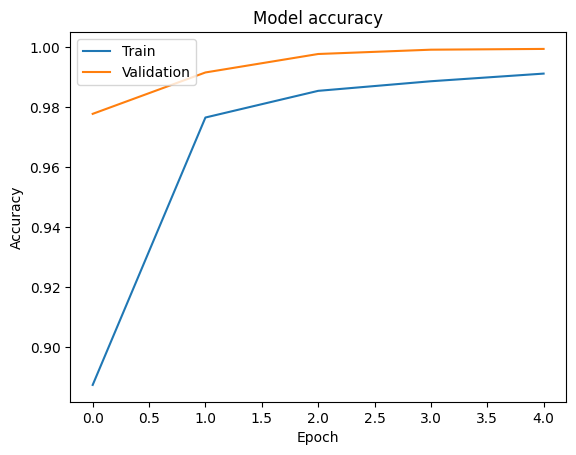

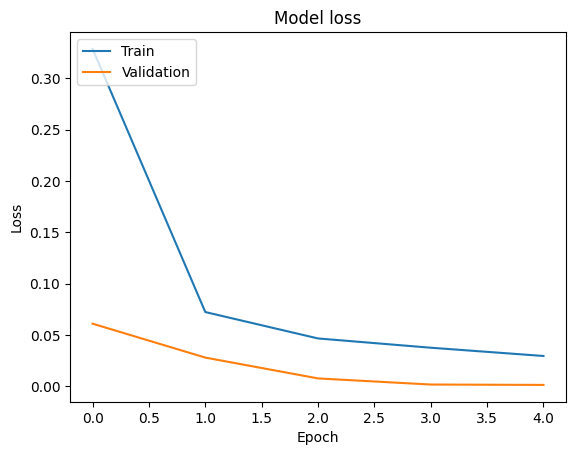

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
# Save the model
model.save('smnist_model_augmented_rgb.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import tensorflow as tf
import os

# Load the model directly using a relative path or absolute path
model_path = 'smnist_model_augmented_rgb.h5' # Adjust this path as necessary
model = tf.keras.models.load_model(model_path)

# Convert the model to TensorFlow Lite format
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()

# Define the path to save the TensorFlow Lite model in Google Drive
drive_path = '/content/drive/My Drive/tf_lite_model.tflite'

# Save the converted model to Google Drive
with open(drive_path, "wb") as f:
    f.write(tflite_model)

print(f"Model converted to TFLite and saved as '{drive_path}'.")

Model converted to TFLite and saved as '/content/drive/My Drive/tf_lite_model.tflite'.


In [13]:
# Adding metadata to the TensorFlow Lite model
!pip install tflite-support-nightly
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils
from google.colab import drive
drive.mount('/content/drive')

ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = '/content/drive/My Drive/tf_lite_model.tflite'
_LABEL_FILE = "/content/drive/MyDrive/label1.txt"
_SAVE_TO_PATH = "/content/drive/MyDrive/model_metadata.tflite"
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD], [_LABEL_FILE]
)

# Verify the metadata generated by metadata writer
print(writer.get_metadata_json())

# Populate the metadata into the model
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
   